# Policy Space Response Oracle (PSRO)
This tutorial demonstrates Policy Space Response Oracle (PSRO) on a zero-sum Markov game, which is more general than extensive-from game (more general than normal-form game). 

For the payoff matrix, row player is maximizer, coloumn player is minimizer.

Reference: A unified game-theoretic approach to multiagent reinforcement learning

In [1]:
import sys
sys.path.append("../..")
from mars.env.mdp import ArbitraryMDP, MDPWrapper
import numpy as np

num_states = 3
num_actions_per_player = 3
num_trans = 3

env = MDPWrapper(ArbitraryMDP(num_states=num_states, num_actions_per_player=num_actions_per_player, num_trans=num_trans))
trans_matrices = env.env.trans_prob_matrices # shape: [dim_transition, dim_state, dim_action (p1*p2), dim_state]
reward_matrices = env.env.reward_matrices # shape: [dim_transition, dim_state, dim_action (p1*p2), dim_state]

oracle_nash_v, oracle_nash_q, oracle_nash_strategies = env.NEsolver(verbose=False)
oracle_v_star = oracle_nash_v[0]

oracle_v_star = np.mean(oracle_v_star, axis=0)
print(env.observation_space, env.action_space)
# env.render()
obs = env.reset()
print(obs)
done = False
while not np.any(done):
    obs, r, done, _ = env.step([1,0])
    print(obs, r, done)
print('Average initial state value of oracle Nash equilibrium for the first player: ', oracle_v_star)


Box(0.0, 12.0, (1,), float32) Discrete(3)
[[0], [0]]
[[5], [5]] [0.5610583525729109, -0.5610583525729109] [False, False]
[[6], [6]] [-0.7261994566288021, 0.7261994566288021] [False, False]
[[9], [9]] [-0.8460871060267345, 0.8460871060267345] [True, True]
Average initial state value of oracle Nash equilibrium for the first player:  -0.29607107415447115


/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:26: UserWarning: Converting G to a CSC matrix; may take a while.
  warn("Converting G to a CSC matrix; may take a while.")
/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:29: UserWarning: Converting A to a CSC matrix; may take a while.
  warn("Converting A to a CSC matrix; may take a while.")


In [2]:
print(np.array(oracle_nash_strategies).shape)
oracle_max_policy = np.array(oracle_nash_strategies)[:, :, 0, :]
print(oracle_max_policy.shape)

(3, 3, 2, 3)
(3, 3, 3)


In [8]:
import copy
from mars.equilibrium_solver import NashEquilibriumECOSSolver, NashEquilibriumCVXPYSolver
import itertools


def sample_from_categorical(dist):
    """
    sample once from a categorical distribution, return the entry index.
    dist: should be a list or array of probabilities for a categorical distribution
    """
    sample_id = np.argmax(np.random.multinomial(1, dist))
    sample_prob = dist[sample_id]
    return sample_id, sample_prob

def unified_state(s):
    unified_s = s[0]%num_states
    return unified_s

def create_expand_policy(zero_ini=False):
    """
    Returns:
    [   [state_dim, action_dim],
        [state_dim, action_dim, action_dim, state_dim, action_dim],
        [state_dim, action_dim, action_dim, state_dim, action_dim, action_dim, state_dim, action_dim],
        ...
    ]
    """
    policies = []
    intial_dim = [num_states]
    for i in range(num_trans):
        if zero_ini:
            policy =  (1./num_actions_per_player) * np.zeros((*intial_dim, num_actions_per_player))
        else:
            policy =  (1./num_actions_per_player) * np.ones((*intial_dim, num_actions_per_player))
        # incremental shape
        intial_dim.extend([num_actions_per_player, num_actions_per_player, num_states])
        policies.append(policy)

    return policies

def create_expand_value():
    """
    Returns:
    [   [state_dim],
        [state_dim, action_dim, action_dim, state_dim],
        [state_dim, action_dim, action_dim, state_dim, action_dim, action_dim, state_dim],
        ...
    ]    
    """
    values = []
    intial_dim = [num_states]
    for i in range(num_trans):
        value =  (1./num_actions_per_player) * np.ones(intial_dim)
        # incremental shape
        intial_dim.extend([num_actions_per_player, num_actions_per_player, num_states])
        values.append(value)

    return values


def create_expand_Q(zero_ini=False):
    """
    Returns:
    [   [state_dim, action_dim, action_dim],
        [state_dim, action_dim, action_dim, state_dim, action_dim, action_dim],
        [state_dim, action_dim, action_dim, state_dim, action_dim, action_dim, state_dim, action_dim, action_dim],
        ...
    ]
    """
    values = []
    intial_dim = [num_states, num_actions_per_player, num_actions_per_player]
    for i in range(num_trans):
        if zero_ini:
            value =  (1./num_actions_per_player) * np.zeros(intial_dim)
        else:
            value =  (1./num_actions_per_player) * np.ones(intial_dim)
        # incremental shape
        intial_dim.extend([num_states, num_actions_per_player, num_actions_per_player])
        values.append(value)

    return values

def get_posterior_policy(policy_set, meta_prior, side):
    posterior_policy = create_expand_policy(zero_ini=True)  # zero initiate to sum later
    num_policies = len(policy_set)

    def get_all_traj_for_transition(num_transition, single_side=False):  # TESTED
        """
        step = 1:
        [
            [s0,a0,b0], [s0,a0,b1],...
        ]
        step = 2:
        [
            [s0,a0,b0,s1,a1,b1], [s1,a0,b0,s1,a1,b1],
        ]
        ...
        """
        if single_side: # lack of one action
            ranges = (num_transition-1)*[range(num_states), range(num_actions_per_player), range(num_actions_per_player)] + [range(num_states), range(num_actions_per_player)]
        else:
            ranges = num_transition*[range(num_states), range(num_actions_per_player), range(num_actions_per_player)]
        all_possible_trajs = list(itertools.product(*ranges))

        return all_possible_trajs

    
    def split_traj(traj, side):  # TESTED
        """
        s0, a0, b0, s1, a1, b1, ... sn-1, an-1, bn-1, sn ->
        side = max:
        [], [s0,a0], [s0,a0,b0,s1,a1], [s0,a0,b0,s1,a1,b1,s2,a2], ...
        side = min:
        [s0,b0], [s0,a0,b0,s1,b1], [s0,a0,b0,s1,a1,b1,s2,b2], ...
        """
        split_trajs = []
        i=2
        while i<=len(traj):  # max length same as original traj but lack of one action (due to the side choice)
            if side == 'max':
                split_trajs.append(traj[:i])
            else:
                split_trajs.append(np.concatenate([traj[:i-1], [traj[i]]]))
            i = i+3 # 3 due to (s,a,b)

        return split_trajs


    def get_likelihood(policy, side):
        likelihoods = create_expand_Q() # (s,a,b) rather than (s,a) or (s,b)
        for i in range(num_trans):
            # number of transitions is i+1
            # each transition is (s,a,b)
            # each trajectory of transitions is [(s1,a1,b1), (s2,a2,b2), ...] of length num_transition
            trajs = get_all_traj_for_transition(num_transition=i+1)   
            for traj in trajs:
                # split trajectories to be a powerset, 
                # and return only one-side action for the last transition,
                # b.c. in likelihood there is only one-side probability
                trajs_list = split_traj(traj, side) 
                likelihood = 1.
                for j, t in enumerate(trajs_list):  # this product corresponding to likelihood for h step (not h-1)
                    likelihood = likelihood*policy[j][tuple(t)]  # scalar
                likelihoods[i][tuple(traj)] = likelihood  # needs to know this likelihood stored for transition i should be used for posterior transition i+1
        return likelihoods

    likelihoods = []
    for pi_i in policy_set:
        likelihoods.append(get_likelihood(pi_i, side))

    def get_denoms(likelihoods, rho):
        denoms = create_expand_Q(zero_ini=True)
        for j, rho_j in enumerate(rho):  # over policy in policy set
            for i in range(len(likelihoods[j])):  # over transition
                trajs = get_all_traj_for_transition(i+1) 
                for traj in trajs:
                    denoms[i][tuple(traj)] += rho_j*likelihoods[j][i][tuple(traj)]

        return denoms

    denoms = get_denoms(likelihoods, meta_prior)

    for pi_i, rho_i, likelihood_i, in zip(policy_set, meta_prior, likelihoods):  # loop over policy set

        for i, (p,) in enumerate(zip(pi_i)): # loop over transition
            taus = get_all_traj_for_transition(i+1, single_side=True)
            for tau in taus:
                if i==0:
                    posterior_policy[i][tuple(tau)] += p[tuple(tau)]*rho_i # posterior = prior for the first transition
                else:
                    tau_h_1 = tau[:-2]  # remove the last (s,a/b) for the likelihood and denominator since they take trajectory until (h-1)
                    # import pdb; pdb.set_trace()
                    posterior_policy[i][tuple(tau)] += p[tuple(tau)]*rho_i*likelihood_i[i-1][tuple(tau_h_1)]/denoms[i-1][tuple(tau_h_1)]

    return posterior_policy

def broadcast_shape(input, output_shape):
    """ broadcast input to have the same shape as output_to_be """
    len_input_shape = len(np.array(input).shape)
    incrs_shape = output_shape[:-len_input_shape]+len_input_shape*(1,)
    output = np.tile(input, incrs_shape)
    return output

def get_best_response_policy(player):
    given_policy = get_posterior_policy(player['policy_set'], player['meta_strategy'], player['side'])
    # print(given_policy)
    br_policy = create_expand_policy()  # best response policy
    br_v = create_expand_value()
    br_q = create_expand_Q()

    for i in range(num_trans-1, -1, -1):  # inverse indexing
        tm = trans_matrices[i]
        rm = reward_matrices[i]

        rm_ = np.array(rm).reshape(num_states, num_actions_per_player, num_actions_per_player, num_states)
        tm_ = np.array(tm).reshape(num_states, num_actions_per_player, num_actions_per_player, num_states)

        expand_rm = broadcast_shape(rm_, br_q[i].shape+(num_states,))  # broadcast the shape of reward matrix to be expand Q shape plus additional state dimension
        if i == num_trans-1:
            expand_tm = broadcast_shape(tm_, expand_rm.shape)
            br_q[i] =  np.sum(expand_rm*expand_tm, axis=-1)
        else:
            v = br_v[i+1]
            v_before_trans = expand_rm + v  # expand_rm and v are same shape
            expand_tm = broadcast_shape(tm_, v_before_trans.shape)  # get the same shape as v_before_trans
            br_q[i] = np.sum(v_before_trans*expand_tm, axis=-1)  # only sum over last dim: state

        if player['side'] == 'max':
            mu_dot_q = np.einsum('...i, ...ij->...j', given_policy[i], br_q[i])
            arg_id = np.argmin(mu_dot_q, axis=-1)  # min player takes minimum as best response against max player's policy
            br_v[i] = np.min(mu_dot_q, axis=-1)
        else:
            q_dot_nu = np.einsum('...ij, ...j->...i', br_q[i], given_policy[i])
            arg_id = np.argmax(q_dot_nu, axis=-1)   # vice versa    
            br_v[i] = np.max(q_dot_nu, axis=-1)     
        
        br_policy[i] = (np.arange(num_actions_per_player) == arg_id[...,None]).astype(int)  # from extreme (min/max) idx to one-hot simplex
        # print(br_policy[i].shape, br_q[i].shape)

    return br_policy

def best_response_value(trans_prob_matrices, reward_matrices, policy, num_actions, side='max'):
    """
    Formulas for calculating best response values:
    1. Nash strategies: (\pi_a^*, \pi_b^*) = \min \max Q(s,a,b), 
        where Q(s,a,b) = r(s,a,b) + \gamma \min \max Q(s',a',b') (this is the definition of Nash Q-value);
    2. Best response (of max player) value: Br V(s) = \min_b \pi(s,a) Br Q(s,a,b)  (Br Q is the oracle best response Q value)
    """
    br_v = create_expand_value()
    br_q = create_expand_Q()

    for i in range(num_trans-1, -1, -1):  # inverse indexing
        tm = trans_matrices[i]
        rm = reward_matrices[i]

        rm_ = np.array(rm).reshape(num_states, num_actions_per_player, num_actions_per_player, num_states)
        tm_ = np.array(tm).reshape(num_states, num_actions_per_player, num_actions_per_player, num_states)
        expand_rm = broadcast_shape(rm_, br_q[i].shape+(num_states,))
        if i == num_trans-1:
            expand_tm = broadcast_shape(tm_, expand_rm.shape)
            br_q[i] =  np.sum(expand_rm*expand_tm, axis=-1)
        else:
            v = br_v[i+1]
            v_before_trans = expand_rm + v  # expand_rm and v are same shape
            expand_tm = broadcast_shape(tm_, v_before_trans.shape)  # get the same shape as v_before_trans
            br_q[i] = np.sum(v_before_trans*expand_tm, axis=-1)  # only sum over last dim: state

        if side == 'max':
            mu_dot_q = np.einsum('...i, ...ij->...j', policy[i], br_q[i])
            br_v[i] = np.min(mu_dot_q, axis=-1)
        else:
            q_dot_nu = np.einsum('...ij, ...j->...i', br_q[i], policy[i])
            br_v[i] = np.max(q_dot_nu, axis=-1)         

    avg_init_br_v = -np.mean(br_v[0])  # average best response value of initial states; minus for making it positive
    return avg_init_br_v

def get_best_response_value(player):
    # wrong! this is the weighted average (by meta strategy) of exploitability for each policy in policy set
    # per_policy_exploits = []
    # for p in policy_set:
    #     per_policy_exploits.append(best_response_value(trans_matrices, reward_matrices, p, num_actions_per_player, player['side']))
    # per_policy_exploits = np.array(per_policy_exploits)
    # print(per_policy_exploits)
    # exploitability = per_policy_exploits @ meta_strategy  # average over policy set weighted by meta strategy

    # should still get the posterior policy as the mixture policy to exploit!
    posterior_policy = get_posterior_policy(player['policy_set'], player['meta_strategy'], player['side'])
    exploitability = best_response_value(trans_matrices, reward_matrices, posterior_policy, num_actions_per_player, player['side'])

    return exploitability

def policy_against_policy_value(trans_prob_matrices, reward_matrices, max_policy, min_policy, num_actions):
    """
    Formulas for calculating best response values:
    1. Nash strategies: (\pi_a^*, \pi_b^*) = \min \max Q(s,a,b), 
        where Q(s,a,b) = r(s,a,b) + \gamma \min \max Q(s',a',b') (this is the definition of Nash Q-value);
    2. Best response (of max player) value: Br V(s) = \min_b \pi(s,a) Br Q(s,a,b)  (Br Q is the oracle best response Q value)
    """
    eval_v = create_expand_value()
    eval_q = create_expand_Q()

    for i in range(num_trans-1, -1, -1):  # inverse indexing
        tm = trans_matrices[i]
        rm = reward_matrices[i]

        rm_ = np.array(rm).reshape(num_states, num_actions_per_player, num_actions_per_player, num_states)
        tm_ = np.array(tm).reshape(num_states, num_actions_per_player, num_actions_per_player, num_states)
        expand_rm = broadcast_shape(rm_, eval_q[i].shape+(num_states,))
        if i == num_trans-1:
            expand_tm = broadcast_shape(tm_, expand_rm.shape)
            eval_q[i] =  np.sum(expand_rm*expand_tm, axis=-1)
        else:
            v = eval_v[i+1]
            v_before_trans = expand_rm + v  # expand_rm and v are same shape
            expand_tm = broadcast_shape(tm_, v_before_trans.shape)  # get the same shape as v_before_trans
            eval_q[i] = np.sum(v_before_trans*expand_tm, axis=-1)  # only sum over last dim: state

        mu_dot_q = np.einsum('...i, ...ij->...j', max_policy[i], eval_q[i])
        mu_dot_q_dot_nu = np.einsum('...kj, ...kj->...k', mu_dot_q, min_policy[i])
        eval_v[i] = mu_dot_q_dot_nu    

    avg_init_eval_v = np.mean(eval_v[0])  # average best response value of initial states; minus for making it positive
    return avg_init_eval_v

def update_matrix(matrix, side, row):
    """
    Adding a new policy to the league will add a row or column to the present evaluation matrix, after it has
    been evaluated against all policies in the opponent's league. Whether adding a row or column depends on whether
    it is the row player (idx=0) or column player (idx=1). 
    For example, if current evaluation matrix is:
    2  1
    -1 3
    After adding a new policy for row player with evaluated average episode reward (a,b) against current two policies in 
    the league of the column player, it gives: 
    it gives:
    2   1
    -1  3
    a   b    
    """ 
    if side == 'max': # for row player
        if matrix.shape[0] == 0: 
            matrix = np.array([row])
        else:  # add row
            matrix = np.vstack([matrix, row])
    else: # for column player
        if matrix.shape[0] == 0:  # the first update
            matrix = np.array([row]) 
        else:  # add column
            matrix=np.hstack([matrix, np.array([row]).T])

    return matrix

def sample_policy(policy_set, dist):
    policy_id, _ = sample_from_categorical(dist)
    policy = policy_set[policy_id]   
    return policy 

# test_policy = create_expand_policy() 
# get_best_response(test_policy)

def psro(env, save_path, solve_episodes = 1000):
    evaluation_matrix = np.array([[0]])
    ini_max_policy = create_expand_policy()
    ini_min_policy = create_expand_policy()
    max_player = {
        'side': 'max',
        'policy_set': [ini_max_policy],
        'meta_strategy': np.array([1.])
    }
    min_player = {
        'side': 'min',
        'policy_set': [ini_min_policy],
        'meta_strategy': np.array([1.])
    }

    max_side_q_table = create_expand_Q()
    min_side_q_table = create_expand_Q()
 
    print('policy shape: ')
    for p in ini_max_policy:
        print(p.shape)
    print('Q table shape: ')
    for q in max_side_q_table:
        print(q.shape)

    exploitability_records = []

    for i in range(solve_episodes):
        
        if i % 2 == 0:  # update min player side
            new_policy = get_best_response_policy(max_player)  # get best response against the max player
            min_player['policy_set'].append(new_policy) # add new policy to policy set to form mixture

            # update evaluation matrix
            eval_scores = []
            for p in max_player['policy_set']:
                score = policy_against_policy_value(trans_matrices, reward_matrices, max_policy=p, min_policy=new_policy, num_actions=num_actions_per_player)
                eval_scores.append(score)  # score always from the max player's view
            evaluation_matrix = update_matrix(evaluation_matrix, 'min', eval_scores)

        else: 
            new_policy = get_best_response_policy(min_player) # get best response against the min player
            max_player['policy_set'].append(new_policy) # add new policy to policy set to form mixture

            # update evaluation matrix
            eval_scores = []
            for p in min_player['policy_set']:
                score = policy_against_policy_value(trans_matrices, reward_matrices, max_policy=new_policy, min_policy=p, num_actions=num_actions_per_player)
                eval_scores.append(score)  # score always from the max player's view
            evaluation_matrix = update_matrix(evaluation_matrix, 'max', eval_scores)

        if len(max_player['policy_set']) * len(min_player['policy_set']) >= 2:  # enough policies to get Nash
            (max_player['meta_strategy'], min_player['meta_strategy']), _ = NashEquilibriumCVXPYSolver(evaluation_matrix)
        else: # uniform for initialization only
            max_policies = len(max_player['policy_set'])
            max_player['meta_strategy'] = 1./max_policies*np.ones(max_policies)
            min_policies = len(min_player['policy_set'])
            min_player['meta_strategy'] = 1./min_policies*np.ones(min_policies)

        if i % 10 == 0:
            exploitability = get_best_response_value(max_player)  # best response of the max player
            print(f'itr: {i}, exploitability: {exploitability}', )
            exploitability_records.append(exploitability)
            np.save(save_path, exploitability_records)

save_path = 'psro_exp.npy'
psro(env, save_path, solve_episodes=1000)

policy shape: 
(3, 3)
(3, 3, 3, 3, 3)
(3, 3, 3, 3, 3, 3, 3, 3)
Q table shape: 
(3, 3, 3)
(3, 3, 3, 3, 3, 3)
(3, 3, 3, 3, 3, 3, 3, 3, 3)
itr: 0, exploitability: 0.7608750685387422
itr: 10, exploitability: 0.6376484629002362
itr: 20, exploitability: 0.5712701680558167
itr: 30, exploitability: 0.4885990951171036
itr: 40, exploitability: 0.49823624270646377
itr: 50, exploitability: 0.4414286175737034
itr: 60, exploitability: 0.4497553799052441
itr: 70, exploitability: 0.41266073665931896
itr: 80, exploitability: 0.3776896500833102
itr: 90, exploitability: 0.4090806504519
itr: 100, exploitability: 0.36277023361898625
itr: 110, exploitability: 0.3655436213761152
itr: 120, exploitability: 0.36700103218322516
itr: 130, exploitability: 0.3525810454654257
itr: 140, exploitability: 0.3496366521265412
itr: 150, exploitability: 0.3439277478444022
itr: 160, exploitability: 0.3440173415810263
itr: 170, exploitability: 0.3304426331108204
itr: 180, exploitability: 0.33348757454717654
itr: 190, exploita

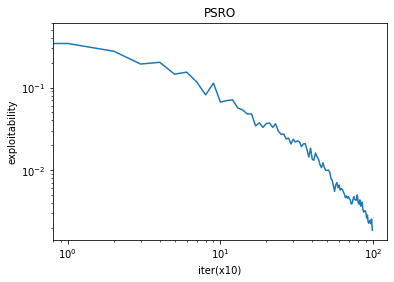

In [9]:
from matplotlib import pyplot as plt

exp_data = np.load(save_path)
plt.title('PSRO')
plt.xlabel('iter(x10)')
plt.ylabel('exploitability')
plt.xscale('log')
plt.yscale('log')
plt.plot(exp_data+oracle_v_star)


In [5]:
# test
import copy
import itertools
import numpy as np

num_states = 3


def get_all_traj_for_transition(transition_step):
    """
    step = 1:
    [
        [s0,a0,b0], [s0,a0,b1],...
    ]
    step = 2:
    [
        [s0,a0,b0,s1,a1,b1], [s1,a0,b0,s1,a1,b1],
    ]
    ...
    """
    ranges = transition_step*[range(num_states), range(num_actions_per_player), range(num_actions_per_player)]
    all_possible_trajs = list(itertools.product(*ranges))

    return all_possible_trajs

def split_traj(traj, side):
    """
    s0, a0, b0, s1, a1, b1, ... sn-1, an-1, bn-1, sn ->
    side = max:
    [], [s0,a0], [s0,a0,b0,s1,a1], [s0,a0,b0,s1,a1,b1,s2,a2], ...
    side = min:
    [s0,b0], [s0,a0,b0,s1,b1], [s0,a0,b0,s1,a1,b1,s2,b2], ...
    """
    split_trajs = []
    i=2
    while i<=len(traj):  # shorter than original traj
        if side == 'max':
            split_trajs.append(traj[:i])
        else:
            split_trajs.append(np.concatenate([traj[:i-1], [traj[i]]]))
        i = i+3 # 3 due to (s,a,b)

    return split_trajs


# get_all_traj_for_transition(2)
split_traj(traj=[0,1,2,3,4,5,6,7,8], side='max')

[[0, 1], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 5, 6, 7]]